In [1]:
import torch
from torch.nn import functional as F
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [6]:
import torchvision.models as models

net = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\13271/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [5]:
class block(nn.Module):
    def __init__(self, inpt_chann, oupt_chann, strides=1, conv1ks=False):
        super(block, self).__init__()
        self.component = nn.Sequential(
            nn.Conv2d(inpt_chann, oupt_chann, kernel_size=3, padding=1, stride=strides),
            nn.BatchNorm2d(oupt_chann),
            nn.ReLU(inplace=True),
            nn.Conv2d(oupt_chann, oupt_chann, kernel_size=3, padding=1),
            nn.BatchNorm2d(oupt_chann)
        )
        if conv1ks:  #shortcut convolution
            self.conv1ks = nn.Conv2d(inpt_chann, oupt_chann, kernel_size=1, stride=strides)
        else:
            self.conv1ks = None
    def forward(self, x):
        # self.component(x)
        if self.conv1ks:
            oupt = self.conv1ks(x) + self.component(x)
        else:
            oupt = x + self.component(x)
        
        return F.relu(oupt)
        
class resnet(nn.Module):
    def __init__(self, inpt_chann, classes):
        super(resnet, self).__init__()
        self.inpt = nn.Sequential(
            nn.Conv2d(inpt_chann, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.residual = nn.Sequential(self._make_layer(64, 64, 2, first_block=True),
                        self._make_layer(64, 128, 2),
                        self._make_layer(128, 256, 2),
                        self._make_layer(256, 512, 2))

        self.oupt = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                  nn.Flatten(), nn.Linear(512, classes))


    def _make_layer(self, inpt_chann, oupt_chann, block_nums, first_block=False):
        blk = []
        for i in range(block_nums):
            if i == 0 and not first_block:
                blk.append(block(inpt_chann, oupt_chann, strides=2, conv1ks=True))
            else:
                blk.append(block(oupt_chann, oupt_chann))
        return nn.Sequential(*blk)

    def forward(self, x):
        h1 = self.inpt(x)
        res = self.residual(h1)
        fc = self.oupt(res)
        return fc

In [6]:
net = resnet(3, 10)

In [7]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.cuda()
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [4]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.cuda()
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
            block-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          36,928
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 64,

In [3]:
## data processing
labels_dataframe = pd.read_csv('./classify-leaves/train.csv')
# test_set = pd.read_csv('./classify-leaves/test.csv')

In [4]:
leaves_labels = sorted(list(set(labels_dataframe['label'])))
n_classes = len(leaves_labels)
print(n_classes)
# leaves_labels

176


In [11]:
num_label_dict = dict(zip(leaves_labels, range(n_classes)))

In [26]:
num_label_dict.values()
transform_to_str = dict()
for i, key in enumerate(num_label_dict.keys()):
    transform_to_str[i] = key

In [5]:
labels_dataframe["label"] = labels_dataframe["label"].apply(lambda row: num_label_dict[row])

NameError: name 'num_label_dict' is not defined

In [34]:
labels_dataframe.to_csv("./classify-leaves/processed_data.csv")

In [57]:
###Define dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

# normalize = transforms.Normalize(
#     mean=[0.485, 0.456, 0.406],
#     std=[0.229, 0.224, 0.225]
# )
preprocess = transforms.Compose([
    #transforms.Scale(256),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    # normalize
])

augprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.ToPILImage(),
    # transforms.CenterCrop(10),
    transforms.RandomHorizontalFlip(),  # 随机水平翻转 选择一个概率
    transforms.RandomVerticalFlip(),  # 随机水平翻转 选择一个概率
    transforms.RandomErasing(),
])

augprocess2 = transforms.Compose([
    transforms.ToTensor(),
    # transforms.ToPILImage(),
    transforms.CenterCrop(112),
    # transforms.RandomHorizontalFlip(),  # 随机水平翻转 选择一个概率
    # transforms.RandomVerticalFlip(),  # 随机水平翻转 选择一个概率
    # transforms.RandomErasing(),
])


def augment_loader2(path):
    img_pil = Image.open(path)
    img_pil = img_pil.resize((224, 224))
    img_tensor = augprocess2(img_pil)
    return img_tensor

def augment_loader(path):
    img_pil = Image.open(path)
    img_pil = img_pil.resize((224, 224))
    img_tensor = augprocess(img_pil)
    return img_tensor

def default_loader(path):
    img_pil =  Image.open(path)
    img_pil = img_pil.resize((224,224))
    img_tensor = preprocess(img_pil)
    return img_tensor


class trainset(Dataset):
    def __init__(self, loader=default_loader, val_ratio=0.3, train=True, val=False):
        #定义好 image 的路径
        data = pd.read_csv("./classify-leaves/processed_data.csv")
        idx = int(len(data)*(1 - 0.3))
        if train:
            self.images_path = data["image"][0:idx].values
            self.label = data["label"][0:idx].values
        elif val:
            self.images_path = data["image"][idx:].values
            self.label = data["label"][idx:].values
        self.loader = loader

    def __getitem__(self, index):
        path = self.images_path[index]
        img = self.loader("./classify-leaves/" + path)
        label= self.label[index]
        return img, label
        
    
    def __len__(self):
       
        return len(self.label)

In [58]:
train_data  = trainset()
train_data2  = trainset(loader=augment_loader)
train_data3  = trainset(loader=augment_loader2)
# val_data = trainset(train=False, val=True)
trainloader = DataLoader(train_data, batch_size=5,shuffle=False)
trainloader2 = DataLoader(train_data2, batch_size=5,shuffle=False)
trainloader3 =  DataLoader(train_data3, batch_size=5,shuffle=False)
# valloader = DataLoader(val_data, batch_size=5,shuffle=True)

In [59]:
dataiter1  = iter(trainloader)
dataiter2 = iter(trainloader2)
dataiter3 = iter(trainloader3)
a, b = dataiter1.next()
aa, _ = dataiter2.next()
aaa, _ = dataiter3.next()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

D:\Applications\Anaconda\anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


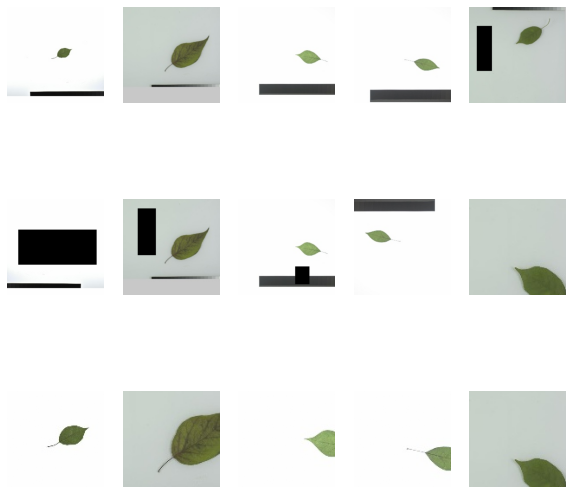

In [73]:
# plt = plt.gcf()
plt.rcParams["figure.figsize"] = (10,10)
for i in range(1, 16):
    if i < 5:
        plt.subplot(3, 5, i)
        plt.imshow(a[i - 1].permute(1,2,0)) # 显示图片
        plt.axis('off') # 不显示坐标轴
    elif i < 10:
        plt.subplot(3, 5, i)
        plt.imshow(aa[i-5 - 1].permute(1,2,0)) # 显示图片
        plt.axis('off') # 不显示坐标轴
    else:
        plt.subplot(3, 5, i)
        plt.imshow(aaa[i-10 - 1].permute(1,2,0)) # 显示图片
        plt.axis('off') # 不显示坐标轴
    
# plt.set_size_inches(18.5, 10.5)
plt.savefig('./fig/vis.png', dpi=100)        
# plt.savefig(fname="./fig/vis.png")   
plt.show()

In [65]:
plt.savefig(fname="./fig/aug.png",format="pdf")

<Figure size 432x288 with 0 Axes>

In [74]:
net = resnet(3, 176)

In [47]:
data = pd.read_csv("./classify-leaves/processed_data.csv")
idx = int(len(data)*(1 - 0.3))
images_path = data["image"][idx:]
label = data["label"][idx:]

In [5]:
learning_rate = 3e-4
wd = 1e-3
n_classes = 176

In [9]:
###train
from model import try_gpu
train_data  = trainset()
val_data = trainset(train=False, val=True)
trainloader = DataLoader(train_data, batch_size=2,shuffle=True)
valloader = DataLoader(val_data, batch_size=2,shuffle=True)
epochs = 1
device = try_gpu()
net = resnet(3, n_classes)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=wd)
loss_fn = nn.CrossEntropyLoss()
for epc in range(epochs):
    train_loss = []
    val_acc = []
     #### train #####
    for X, Y in trainloader:
        X, Y = X.to(device), Y.to(device)
        oupt = net(X)
        optimizer.zero_grad()
        loss = loss_fn(oupt, Y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.data)
        
    epoch_loss = sum(train_loss)/len(train_loss)
    print(f"Training Loss:{epoch_loss:.2f}, Epoch:{epc}/{epochs}", end = "//")
        
        
    #### val #####
    for X, Y in valloader:
        X, Y = X.to(device), Y.to(device)   
        with torch.no_grad(): 
            pred = net(X)
            acc = (pred.argmax(dim=-1) == Y).float().mean()
        val_acc.append(acc.item())
    mean_acc = sum(val_acc)/len(val_acc)
    print(f"Validation Acc:{mean_acc:.2f}, Epoch:{epc}/{epochs}")

Training Loss:5.98, Epoch:0/1//Training Loss:5.59, Epoch:0/1//Training Loss:5.52, Epoch:0/1//Training Loss:5.49, Epoch:0/1//Training Loss:5.40, Epoch:0/1//

Training Loss:5.46, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.34, Epoch:0/1

//Training Loss:5.39, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.45, Epoch:0/1//

Training Loss:5.57, Epoch:0/1//Training Loss:5.50, Epoch:0/1//Training Loss:5.46, Epoch:0/1//

Training Loss:5.36, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.41, Epoch:0/1

//Training Loss:5.45, Epoch:0/1//Training Loss:5.51, Epoch:0/1//

Training Loss:5.48, Epoch:0/1//Training Loss:5.50, Epoch:0/1//Training Loss:5.53, Epoch:0/1//

Training Loss:5.58, Epoch:0/1//Training Loss:5.61, Epoch:0/1//Training Loss:5.65, Epoch:0/1//

Training Loss:5.64, Epoch:0/1//Training Loss:5.68, Epoch:0/1//Training Loss:5.69, Epoch:0/1

//Training Loss:5.70, Epoch:0/1//Training Loss:5.70, Epoch:0/1//Training Loss:5.69, Epoch:0/1//Training Loss:5.71, Epoch:0/1

//Training Loss:5.73, Epoch:0/1//Training Loss:5.71, Epoch:0/1//Training Loss:5.73, Epoch:0/1//Training Loss:5.76, Epoch:0/1//Training Loss:5.75, Epoch:0/1

//Training Loss:5.76, Epoch:0/1//Training Loss:5.72, Epoch:0/1//Training Loss:5.72, Epoch:0/1//Training Loss:5.73, Epoch:0/1//Training Loss:5.75, Epoch:0/1

//Training Loss:5.76, Epoch:0/1//Training Loss:5.75, Epoch:0/1//Training Loss:5.75, Epoch:0/1//Training Loss:5.75, Epoch:0/1//Training Loss:5.76, Epoch:0/1

//Training Loss:5.74, Epoch:0/1//Training Loss:5.74, Epoch:0/1//Training Loss:5.73, Epoch:0/1//Training Loss:5.71, Epoch:0/1//

Training Loss:5.73, Epoch:0/1//Training Loss:5.75, Epoch:0/1//Training Loss:5.74, Epoch:0/1//Training Loss:5.75, Epoch:0/1//Training Loss:5.74, Epoch:0/1//

Training Loss:5.74, Epoch:0/1//Training Loss:5.76, Epoch:0/1//Training Loss:5.77, Epoch:0/1//Training Loss:5.78, Epoch:0/1//Training Loss:5.78, Epoch:0/1//Training Loss:5.78, Epoch:0/1

//Training Loss:5.76, Epoch:0/1//Training Loss:5.78, Epoch:0/1//Training Loss:5.77, Epoch:0/1//Training Loss:5.75, Epoch:0/1//Training Loss:5.76, Epoch:0/1

//Training Loss:5.76, Epoch:0/1//Training Loss:5.76, Epoch:0/1//Training Loss:5.75, Epoch:0/1//Training Loss:5.75, Epoch:0/1//Training Loss:5.75, Epoch:0/1

//Training Loss:5.76, Epoch:0/1//Training Loss:5.77, Epoch:0/1//Training Loss:5.77, Epoch:0/1//Training Loss:5.77, Epoch:0/1//Training Loss:5.75, Epoch:0/1

//Training Loss:5.75, Epoch:0/1//Training Loss:5.74, Epoch:0/1//Training Loss:5.73, Epoch:0/1//Training Loss:5.71, Epoch:0/1//Training Loss:5.72, Epoch:0/1

//Training Loss:5.72, Epoch:0/1//Training Loss:5.73, Epoch:0/1//Training Loss:5.73, Epoch:0/1//

Training Loss:5.72, Epoch:0/1//Training Loss:5.73, Epoch:0/1//Training Loss:5.71, Epoch:0/1//Training Loss:5.72, Epoch:0/1//Training Loss:5.71, Epoch:0/1//Training Loss:5.72, Epoch:0/1

//Training Loss:5.73, Epoch:0/1//Training Loss:5.73, Epoch:0/1//Training Loss:5.73, Epoch:0/1//Training Loss:5.73, Epoch:0/1//Training Loss:5.72, Epoch:0/1

//Training Loss:5.73, Epoch:0/1//Training Loss:5.71, Epoch:0/1//Training Loss:5.72, Epoch:0/1//Training Loss:5.72, Epoch:0/1//Training Loss:5.71, Epoch:0/1

//Training Loss:5.71, Epoch:0/1//Training Loss:5.72, Epoch:0/1//Training Loss:5.73, Epoch:0/1//Training Loss:5.74, Epoch:0/1//Training Loss:5.75, Epoch:0/1

//Training Loss:5.75, Epoch:0/1//Training Loss:5.74, Epoch:0/1//Training Loss:5.74, Epoch:0/1//Training Loss:5.74, Epoch:0/1//Training Loss:5.74, Epoch:0/1

//Training Loss:5.73, Epoch:0/1//Training Loss:5.73, Epoch:0/1//Training Loss:5.72, Epoch:0/1//Training Loss:5.72, Epoch:0/1//Training Loss:5.72, Epoch:0/1

//Training Loss:5.71, Epoch:0/1//Training Loss:5.72, Epoch:0/1//Training Loss:5.72, Epoch:0/1//Training Loss:5.71, Epoch:0/1//Training Loss:5.71, Epoch:0/1

//Training Loss:5.71, Epoch:0/1//Training Loss:5.71, Epoch:0/1//Training Loss:5.70, Epoch:0/1//Training Loss:5.70, Epoch:0/1//Training Loss:5.71, Epoch:0/1

//Training Loss:5.71, Epoch:0/1//Training Loss:5.70, Epoch:0/1//Training Loss:5.70, Epoch:0/1//Training Loss:5.70, Epoch:0/1//Training Loss:5.71, Epoch:0/1

//Training Loss:5.70, Epoch:0/1//Training Loss:5.70, Epoch:0/1//Training Loss:5.70, Epoch:0/1//Training Loss:5.69, Epoch:0/1//Training Loss:5.69, Epoch:0/1

//Training Loss:5.68, Epoch:0/1//Training Loss:5.68, Epoch:0/1//Training Loss:5.68, Epoch:0/1//Training Loss:5.67, Epoch:0/1//Training Loss:5.68, Epoch:0/1

//Training Loss:5.67, Epoch:0/1//Training Loss:5.68, Epoch:0/1//Training Loss:5.68, Epoch:0/1//Training Loss:5.67, Epoch:0/1//Training Loss:5.68, Epoch:0/1

//Training Loss:5.68, Epoch:0/1//Training Loss:5.67, Epoch:0/1//Training Loss:5.66, Epoch:0/1//Training Loss:5.66, Epoch:0/1//Training Loss:5.66, Epoch:0/1

//Training Loss:5.67, Epoch:0/1//Training Loss:5.67, Epoch:0/1//Training Loss:5.66, Epoch:0/1//Training Loss:5.65, Epoch:0/1//Training Loss:5.66, Epoch:0/1

//Training Loss:5.65, Epoch:0/1//Training Loss:5.65, Epoch:0/1//Training Loss:5.64, Epoch:0/1//Training Loss:5.64, Epoch:0/1//

Training Loss:5.64, Epoch:0/1//Training Loss:5.63, Epoch:0/1//Training Loss:5.64, Epoch:0/1//Training Loss:5.64, Epoch:0/1//Training Loss:5.64, Epoch:0/1//Training Loss:5.64, Epoch:0/1

//Training Loss:5.63, Epoch:0/1//Training Loss:5.63, Epoch:0/1//Training Loss:5.63, Epoch:0/1//Training Loss:5.62, Epoch:0/1//Training Loss:5.62, Epoch:0/1

//Training Loss:5.62, Epoch:0/1//Training Loss:5.61, Epoch:0/1//Training Loss:5.61, Epoch:0/1//Training Loss:5.61, Epoch:0/1//Training Loss:5.62, Epoch:0/1

//Training Loss:5.61, Epoch:0/1//Training Loss:5.61, Epoch:0/1//Training Loss:5.61, Epoch:0/1//Training Loss:5.60, Epoch:0/1//Training Loss:5.61, Epoch:0/1//

Training Loss:5.60, Epoch:0/1//Training Loss:5.60, Epoch:0/1//Training Loss:5.60, Epoch:0/1//Training Loss:5.59, Epoch:0/1//Training Loss:5.60, Epoch:0/1//Training Loss:5.59, Epoch:0/1

//Training Loss:5.59, Epoch:0/1//Training Loss:5.59, Epoch:0/1//Training Loss:5.58, Epoch:0/1//Training Loss:5.58, Epoch:0/1//Training Loss:5.58, Epoch:0/1//

Training Loss:5.58, Epoch:0/1//Training Loss:5.58, Epoch:0/1//Training Loss:5.58, Epoch:0/1//Training Loss:5.57, Epoch:0/1//Training Loss:5.57, Epoch:0/1//Training Loss:5.57, Epoch:0/1//

Training Loss:5.57, Epoch:0/1//Training Loss:5.57, Epoch:0/1//Training Loss:5.57, Epoch:0/1//Training Loss:5.56, Epoch:0/1//Training Loss:5.56, Epoch:0/1//Training Loss:5.56, Epoch:0/1

//Training Loss:5.56, Epoch:0/1//Training Loss:5.56, Epoch:0/1//Training Loss:5.56, Epoch:0/1//Training Loss:5.55, Epoch:0/1//Training Loss:5.55, Epoch:0/1//Training Loss:5.55, Epoch:0/1

//Training Loss:5.55, Epoch:0/1//Training Loss:5.55, Epoch:0/1//Training Loss:5.54, Epoch:0/1//Training Loss:5.55, Epoch:0/1//Training Loss:5.55, Epoch:0/1

//Training Loss:5.55, Epoch:0/1//Training Loss:5.55, Epoch:0/1//Training Loss:5.54, Epoch:0/1//Training Loss:5.54, Epoch:0/1//Training Loss:5.54, Epoch:0/1//Training Loss:5.53, Epoch:0/1//

Training Loss:5.53, Epoch:0/1//Training Loss:5.53, Epoch:0/1//Training Loss:5.53, Epoch:0/1//Training Loss:5.52, Epoch:0/1//Training Loss:5.52, Epoch:0/1//Training Loss:5.52, Epoch:0/1//Training Loss:5.52, Epoch:0/1

//Training Loss:5.52, Epoch:0/1//Training Loss:5.51, Epoch:0/1//Training Loss:5.51, Epoch:0/1//Training Loss:5.51, Epoch:0/1//Training Loss:5.51, Epoch:0/1//

Training Loss:5.52, Epoch:0/1//Training Loss:5.52, Epoch:0/1//Training Loss:5.52, Epoch:0/1//Training Loss:5.51, Epoch:0/1//Training Loss:5.51, Epoch:0/1//Training Loss:5.51, Epoch:0/1//Training Loss:5.51, Epoch:0/1//

Training Loss:5.51, Epoch:0/1//Training Loss:5.51, Epoch:0/1//Training Loss:5.51, Epoch:0/1//Training Loss:5.50, Epoch:0/1//Training Loss:5.50, Epoch:0/1//Training Loss:5.50, Epoch:0/1

//Training Loss:5.50, Epoch:0/1//Training Loss:5.50, Epoch:0/1//Training Loss:5.50, Epoch:0/1//Training Loss:5.49, Epoch:0/1//Training Loss:5.49, Epoch:0/1//

Training Loss:5.49, Epoch:0/1//Training Loss:5.49, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1//

Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1

//Training Loss:5.48, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1

//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1

//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.48, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1//

Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1//

Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1

//Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.47, Epoch:0/1//Training Loss:5.46, Epoch:0/1//Training Loss:5.46, Epoch:0/1

//Training Loss:5.46, Epoch:0/1//Training Loss:5.46, Epoch:0/1//Training Loss:5.46, Epoch:0/1//Training Loss:5.46, Epoch:0/1//Training Loss:5.46, Epoch:0/1//

Training Loss:5.46, Epoch:0/1//Training Loss:5.46, Epoch:0/1//Training Loss:5.46, Epoch:0/1//Training Loss:5.45, Epoch:0/1//Training Loss:5.45, Epoch:0/1//Training Loss:5.45, Epoch:0/1

//Training Loss:5.45, Epoch:0/1//Training Loss:5.45, Epoch:0/1//Training Loss:5.45, Epoch:0/1//Training Loss:5.45, Epoch:0/1//Training Loss:5.45, Epoch:0/1//Training Loss:5.45, Epoch:0/1

//Training Loss:5.45, Epoch:0/1//Training Loss:5.45, Epoch:0/1//Training Loss:5.45, Epoch:0/1//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1

//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1

//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1

//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1

//Training Loss:5.43, Epoch:0/1//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1//Training Loss:5.43, Epoch:0/1//

Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1//Training Loss:5.44, Epoch:0/1//Training Loss:5.43, Epoch:0/1//Training Loss:5.43, Epoch:0/1//Training Loss:5.43, Epoch:0/1

//Training Loss:5.43, Epoch:0/1//Training Loss:5.43, Epoch:0/1//Training Loss:5.43, Epoch:0/1//Training Loss:5.43, Epoch:0/1//Training Loss:5.43, Epoch:0/1//Training Loss:5.43, Epoch:0/1

//Training Loss:5.43, Epoch:0/1//Training Loss:5.43, Epoch:0/1//Training Loss:5.43, Epoch:0/1//Training Loss:5.43, Epoch:0/1//Training Loss:5.43, Epoch:0/1//

Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.43, Epoch:0/1//Training Loss:5.43, Epoch:0/1//Training Loss:5.42, Epoch:0/1//

Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//

Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//

Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//

Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1

//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//

Training Loss:5.42, Epoch:0/1//Training Loss:5.42, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1

//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1

//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1

//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//

Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1

//Training Loss:5.41, Epoch:0/1//Training Loss:5.41, Epoch:0/1//Training Loss:5.40, Epoch:0/1//Training Loss:5.40, Epoch:0/1//Training Loss:5.40, Epoch:0/1//

Training Loss:5.40, Epoch:0/1//Training Loss:5.40, Epoch:0/1//Training Loss:5.40, Epoch:0/1//Training Loss:5.40, Epoch:0/1//Training Loss:5.40, Epoch:0/1//Training Loss:5.40, Epoch:0/1//Training Loss:5.40, Epoch:0/1

//Training Loss:5.40, Epoch:0/1//Training Loss:5.40, Epoch:0/1//Training Loss:5.39, Epoch:0/1//Training Loss:5.39, Epoch:0/1//Training Loss:5.39, Epoch:0/1

//Training Loss:5.39, Epoch:0/1//Training Loss:5.39, Epoch:0/1//Training Loss:5.39, Epoch:0/1//Training Loss:5.39, Epoch:0/1//Training Loss:5.39, Epoch:0/1

//Training Loss:5.39, Epoch:0/1//Training Loss:5.39, Epoch:0/1//Training Loss:5.39, Epoch:0/1//Training Loss:5.39, Epoch:0/1//Training Loss:5.38, Epoch:0/1

//Training Loss:5.38, Epoch:0/1//Training Loss:5.38, Epoch:0/1//Training Loss:5.38, Epoch:0/1//Training Loss:5.38, Epoch:0/1//Training Loss:5.38, Epoch:0/1//

Training Loss:5.38, Epoch:0/1//Training Loss:5.38, Epoch:0/1//Training Loss:5.38, Epoch:0/1//Training Loss:5.38, Epoch:0/1//Training Loss:5.38, Epoch:0/1//Training Loss:5.38, Epoch:0/1//

Training Loss:5.38, Epoch:0/1//Training Loss:5.38, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.38, Epoch:0/1//

Training Loss:5.38, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1

//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.38, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1

//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1

//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1

//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1

//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1

//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1

//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1

//Training Loss:5.37, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1

//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1

//Training Loss:5.37, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//

Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.36, Epoch:0/1

//Training Loss:5.36, Epoch:0/1//Training Loss:5.37, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1

//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1

//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1

//Training Loss:5.36, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1

//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//

Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.36, Epoch:0/1//

Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.36, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1

//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1

//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1

//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1//Training Loss:5.35, Epoch:0/1

//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1

//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1

//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1

//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1

//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//

Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.34, Epoch:0/1//Training Loss:5.33, Epoch:0/1

//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//

Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//

Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1

//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1

//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.33, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.33, Epoch:0/1

//Training Loss:5.33, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1

//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1

//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1

//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1

//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.32, Epoch:0/1//Training Loss:5.32, Epoch:0/1

//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1

//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1

//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1

//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1

//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.31, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1

//Training Loss:5.31, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1

//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1

//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//

Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1

//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1

//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1

//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1

//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1

//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1

//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1

//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1

//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1

//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.30, Epoch:0/1

//Training Loss:5.30, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1

//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1

//Training Loss:5.29, Epoch:0/1//Training Loss:5.30, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1

//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1

//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1

//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1

//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1

//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1

//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//

Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1

//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1

//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1

//Training Loss:5.29, Epoch:0/1//Training Loss:5.29, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1

//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1

//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1

//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1

//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//

Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1

//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1

//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1

//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1

//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1

//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1

//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1

//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1

//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1

//Training Loss:5.28, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1//Training Loss:5.28, Epoch:0/1

//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1

//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1

//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1

//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1

//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1

//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1

//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1

//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//

Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//

Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//

Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1

//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1

//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//

Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//

Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1//Training Loss:5.27, Epoch:0/1

//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1

//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1

//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1

//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1

//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//

Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//

Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1

//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1

//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.26, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1

//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1

//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//

Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1

//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//

Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1

//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1

//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1

//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1

//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1

//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1

//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1

//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1

//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1

//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//

Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.25, Epoch:0/1//Training Loss:5.24, Epoch:0/1//Training Loss:5.25, Epoch:0/1

//Training Loss:5.24, Epoch:0/1//Training Loss:5.24, Epoch:0/1//Training Loss:5.24, Epoch:0/1//Training Loss:5.24, Epoch:0/1//Training Loss:5.24, Epoch:0/1

//

KeyboardInterrupt: 

In [11]:
torch.save(net, "resnet.pth")

## Augmentation

## Visualization

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')  #生成eps
import seaborn as sns
sns.set_style('whitegrid')

D:\Applications\Anaconda\anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


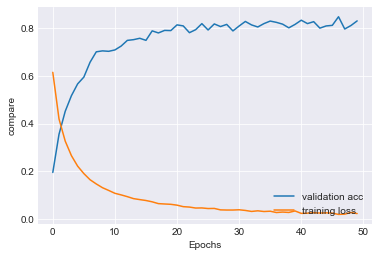

In [6]:
acc = np.load("./exp/val_acc_normal.npy")
loss = np.load("./exp/train_loss_normal.npy")
plt.style.use("seaborn-darkgrid")
loss_normalized =  loss/np.linalg.norm(loss)
plt.plot(np.arange(len(acc)), acc, label="validation acc")
plt.plot(np.arange(len(acc)), loss_normalized, label="training loss")
plt.xlabel('Epochs')
plt.ylabel('compare')
# plt.title("N20_M2_L20_server_clientnum5")
# plt.title("Pendulum")
# plt.title('DQN on {}'.format(env_name))
plt.legend(loc='lower right') # 图例在图形里面
plt.show()
plt.savefig(fname="./fig/default.pdf",format="pdf")

D:\Applications\Anaconda\anaconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


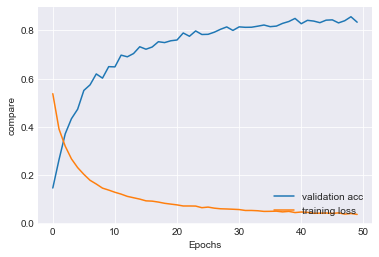

In [7]:
#augmentation 1
acc = np.load("./exp/val_acc_aug.npy")
loss = np.load("./exp/train_loss_aug.npy")
plt.style.use("seaborn-darkgrid")
loss_normalized =  loss/np.linalg.norm(loss)
plt.plot(np.arange(len(acc)), acc, label="validation acc")
plt.plot(np.arange(len(acc)), loss_normalized, label="training loss")
plt.xlabel('Epochs')
plt.ylabel('compare')
# plt.title("N20_M2_L20_server_clientnum5")
# plt.title("Pendulum")
# plt.title('DQN on {}'.format(env_name))
plt.legend(loc='lower right') # 图例在图形里面
plt.show()
plt.savefig(fname="./fig/aug1.pdf",format="pdf")

D:\Applications\Anaconda\anaconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


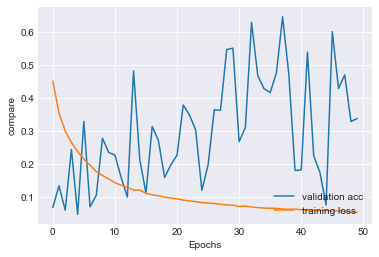

In [8]:
#augmentation 2
acc = np.load("./exp/val_acc_aug2.npy")
loss = np.load("./exp/train_loss_aug2.npy")
plt.style.use("seaborn-darkgrid")
loss_normalized =  loss/np.linalg.norm(loss)
plt.plot(np.arange(len(acc)), acc, label="validation acc")
plt.plot(np.arange(len(acc)), loss_normalized, label="training loss")
plt.xlabel('Epochs')
plt.ylabel('compare')
# plt.title("N20_M2_L20_server_clientnum5")
# plt.title("Pendulum")
# plt.title('DQN on {}'.format(env_name))
plt.legend(loc='lower right') # 图例在图形里面
plt.show()
plt.savefig(fname="./fig/aug2.pdf",format="pdf")

D:\Applications\Anaconda\anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


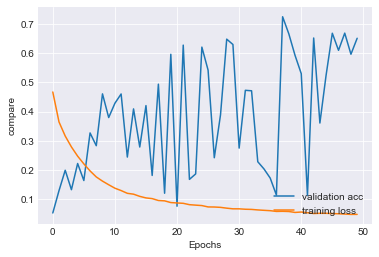

In [9]:
acc = np.load("./exp/val_acc_aug3.npy")
loss = np.load("./exp/train_loss_aug3.npy")
plt.style.use("seaborn-darkgrid")
loss_normalized =  loss/np.linalg.norm(loss)
plt.plot(np.arange(len(acc)), acc, label="validation acc")
plt.plot(np.arange(len(acc)), loss_normalized, label="training loss")
plt.xlabel('Epochs')
plt.ylabel('compare')
# plt.title("N20_M2_L20_server_clientnum5")
# plt.title("Pendulum")
# plt.title('DQN on {}'.format(env_name))
plt.legend(loc='lower right') # 图例在图形里面
plt.show()
plt.savefig(fname="./fig/aug3.pdf",format="pdf")

D:\Applications\Anaconda\anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


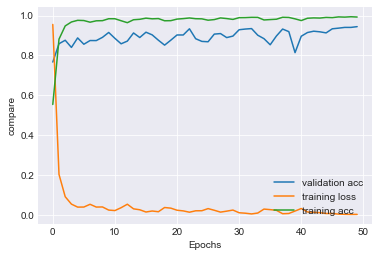

In [6]:
acc = np.load("./exp/val_acc_pre.npy")
loss = np.load("./exp/train_loss_pre.npy")
train_acc = np.load("./exp/train_acc_pre.npy")
plt.style.use("seaborn-darkgrid")
loss_normalized =  loss/np.linalg.norm(loss)
plt.plot(np.arange(len(acc)), acc, label="validation acc")
plt.plot(np.arange(len(acc)), loss_normalized, label="training loss")
plt.plot(np.arange(len(acc)), train_acc, label="training acc")
plt.xlabel('Epochs')
plt.ylabel('compare')
# plt.title("N20_M2_L20_server_clientnum5")
# plt.title("Pendulum")
# plt.title('DQN on {}'.format(env_name))
plt.legend(loc='lower right') # 图例在图形里面
plt.show()
plt.savefig(fname="./fig/predefault.pdf",format="pdf")

In [3]:
acc = np.load("./exp/val_acc_preaug.npy")
loss = np.load("./exp/train_loss_preaug.npy")
train_acc = np.load("./exp/train_acc_preaug.npy")
plt.style.use("seaborn-darkgrid")
loss_normalized =  loss/np.linalg.norm(loss)
plt.plot(np.arange(len(acc)), acc, label="validation acc")
plt.plot(np.arange(len(acc)), loss_normalized, label="training loss")
plt.plot(np.arange(len(acc)), train_acc, label="training acc")
plt.xlabel('Epochs')
plt.ylabel('compare')
# plt.title("N20_M2_L20_server_clientnum5")
# plt.title("Pendulum")
# plt.title('DQN on {}'.format(env_name))
plt.legend(loc='lower right') # 图例在图形里面
plt.show()
plt.savefig(fname="./fig/preaug.pdf",format="pdf")

D:\Applications\Anaconda\anaconda\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app
